In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import KFold
import re
from tqdm.notebook import trange, tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
def gaussian_kernel(X1_tensor, X2_tensor, j=None, h=1):
    '''
    Computes the Gaussian kernel matrix for a specific covariate between two tensors.
    If j is None, computes the Gaussian kernel matrix for the entire tensor.

    Parameters:
    X1_tensor (torch.Tensor): n1 x d tensor, where X1_tensor[i, j] is the j-th covariate of the i-th player in the first tensor
    X2_tensor (torch.Tensor): n2 x d tensor, where X2_tensor[i, j] is the j-th covariate of the i-th player in the second tensor
    j (int, optional): Index of the covariate of choice. If None, computes the kernel for the entire tensor.
    h (float): Bandwidth parameter for the Gaussian kernel

    Returns:
    torch.Tensor: Kernel matrix K (n1 x n2)
    '''
    if j is None:
        pairwise_sq_dists = torch.cdist(X1_tensor, X2_tensor, p=2)**2
    else:
        X1_j = X1_tensor[:, j].unsqueeze(1)  # Shape: n1 x 1
        X2_j = X2_tensor[:, j].unsqueeze(1)  # Shape: n2 x 1
        pairwise_sq_dists = torch.cdist(X1_j, X2_j, p=2)**2
        
    K = torch.exp(-pairwise_sq_dists / (2 * h**2))
    return K

In [4]:
def precompute_kernels(X1_tensor, X2_tensor, h=1):
    '''
    Precomputes the kernel matrices for each covariate and combines them into a d x n1 x n2 tensor.

    Parameters:
    X1_tensor (torch.Tensor): n1 x d tensor of covariates
    X2_tensor (torch.Tensor): n2 x d tensor of covariates
    h (float): Bandwidth parameter for the Gaussian kernel

    Returns:
    torch.Tensor: Combined kernel tensor of shape d x n1 x n2
    '''
    n1, d = X1_tensor.shape
    n2 = X2_tensor.shape[0]
    kernel_tensor = torch.zeros(d, n1, n2)

    for j in range(d):
        kernel_tensor[j, :, :] = gaussian_kernel(X1_tensor, X2_tensor, j, h)

    return kernel_tensor

In [5]:
def delta_f(g, theta, games, kernel_tensor):
    '''
    Computes delta_f(g) as defined in the given expression.

    Parameters:
    g (int): Index of the game
    theta (torch.Tensor): d x n1 tensor of parameters
    games (torch.Tensor): G x 3 tensor, where G[g,0] is the outcome of game g 
        and the other columns contains indices of players in a game
    kernel_tensor (torch.Tensor): Precomputed kernel tensor of shape d x n1 x n2

    Returns:
    torch.Tensor: delta_f(g) value
    '''
    _,g1, g2 = games[g]
    d = kernel_tensor.shape[0]
    delta = 0

    for j in range(d):
        k_ij_g1 = kernel_tensor[j, :, g1]
        k_ij_g2 = kernel_tensor[j, :, g2]
        delta += torch.sum(theta[j] * (k_ij_g1 - k_ij_g2))
    
    return delta

In [6]:
def delta_f(theta, games, kernel_tensor):
    '''
    Computes delta_f for all games.

    Parameters:
    theta (torch.Tensor): d x n tensor of parameters
    games (torch.Tensor): G x 3 tensor, where G[g,0] is the outcome of game g 
        and the other columns contains indices of players in a game
    kernel_tensor (torch.Tensor): Precomputed kernel tensor of shape d x n x n

    Returns:
    torch.Tensor: delta_f values for all games (G length tensor)
    '''
    G = games.shape[0]
    d = theta.shape[0]
    delta = torch.zeros(G)

    for j in range(d):
        K_j = kernel_tensor[j, :, :]  # n x n
        g1_indices = games[:, 1].long()
        g2_indices = games[:, 2].long()
        delta += torch.matmul(K_j[g1_indices], theta[j]) - torch.matmul(K_j[g2_indices], theta[j])
    
    return delta

In [7]:
def f_j(j, x_values_new, X_tensor_train, theta, h):
    '''
    Computes f^{(j)} for a given j and range of x values, subtracting the mean value of f_j for X_tensor.

    Parameters:
    j (int): Index of the covariate
    x_values_new (torch.Tensor): n2 length tensor of covariate j
    X_tensor (torch.Tensor): n1 x d tensor of covariates
    theta (torch.Tensor): d x n1 tensor of optimized parameters
    h (float): Bandwidth parameter for the Gaussian kernel

    Returns:
    torch.Tensor: Computed values of f^{(j)} for the given x values, adjusted by subtracting the mean value
    '''
    X_new_j = x_values_new.unsqueeze(1)  # Shape: n2 x 1
    X_j = X_tensor_train[:, j].unsqueeze(1)  # Shape: n1 x 1
    
    K_j_new = gaussian_kernel(X_new_j, X_j, j=None, h=h)
    f_j_new_values = torch.matmul(K_j_new, theta[j])
    
    # Compute the kernel matrix for X_tensor itself
    K_j_self = gaussian_kernel(X_j, X_j, j=None, h=h)
    f_j_self_values = torch.matmul(K_j_self, theta[j])
    
    # Compute the mean of f_j values for X_tensor
    mean_f_j = torch.mean(f_j_self_values)
    
    # Subtract the mean from each f_j value for the new x values
    f_j_adjusted_values = f_j_new_values - mean_f_j
    
    return f_j_adjusted_values

In [8]:
def objective_function(alpha, theta, games, kernel_tensor, lbda):
    '''
    Computes the objective function to be minimized.

    Parameters:
    alpha (torch.Tensor): G tensor of intercepts
    theta (torch.Tensor): d x n tensor of parameters
    games (torch.Tensor): G x 3 tensor, where G[g,0] is the outcome of game g 
        and the other columns contains indices of players in a game
    kernel_tensor (torch.Tensor): Precomputed kernel tensor of shape n x n x d
    lambd (float): Regularization parameter

    Returns:
    torch.Tensor: Objective function value
    '''
    G = games.shape[0]
    y_g = games[:, 0]  # G tensor
    g1_indices = games[:, 1].long()  # G tensor
    g2_indices = games[:, 2].long()  # G tensor

    # Compute delta for all games
    delta = delta_f(theta, games, kernel_tensor)

    # Vectorized computation of the objective function
    alpha_diff = alpha[g1_indices] - alpha[g2_indices]  # G tensor
    logits = alpha_diff + delta  # G tensor

    # Objective function
    obj = torch.sum(y_g * logits - torch.log(1 + torch.exp(logits)))
    
    d = theta.shape[0]
    regularization = 0
    for j in range(d):
        K_j = kernel_tensor[j, :, :]
        regularization += torch.matmul(theta[j], torch.matmul(K_j, theta[j]))
        
    return -obj/G + lbda * regularization

In [174]:
def optimize_theta(X_tensor, games, h=1.0, lbda=1.0, lr=0.01, epochs=500, show_progress=True):
    '''
    Optimizes the objective function, given all alpha_i = 0

    Parameters:
    X_tensor (torch.Tensor): n x d tensor of covariates
    games (torch.Tensor): G x 3 tensor, where G[g,0] is the outcome of game g 
        and the other columns contain indices of players in a game
    h (float): Bandwidth parameter for the Gaussian kernel
    lbda (float): Regularization parameter
    lr (float): Learning rate
    epochs (int): Number of epochs

    Returns:
    torch.Tensor: Optimized theta
    '''
    G = games.shape[0]
    n, d = X_tensor.shape

    alpha = torch.zeros(n, requires_grad=False)
    theta = torch.zeros(d, n, requires_grad=True)

    kernel_tensor = precompute_kernels(X_tensor, X_tensor, h)
    
    optimizer = torch.optim.Adam([theta], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.9)

    for epoch in tqdm(range(epochs), display=show_progress):
        optimizer.zero_grad()
        loss = objective_function(alpha, theta, games, kernel_tensor, lbda)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if show_progress and (epoch % (epochs//10) == 0):
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return theta

In [10]:
def optimize_alpha(X_tensor, theta, games, h=1.0, lbda=1.0, lr=0.01, epochs=500, show_progress=True):
    '''
    Optimizes the objective function, given our optimal thetas

    Parameters:
    Y (torch.Tensor): G tensor of labels
    X_tensor (torch.Tensor): n x d tensor of covariates
    games (torch.Tensor): G x 3 tensor, where G[g,0] is the outcome of game g 
        and the other columns contains indices of players in a game
    kernel_function (function): Function to compute the kernel matrix
    lambd (float): Regularization parameter
    lr (float): Learning rate
    epochs (int): Number of epochs

    Returns:
    torch.Tensor: Optimized alpha and theta
    '''
    G = games.shape[0]
    n, d = X_tensor.shape

    alpha = torch.zeros(n, requires_grad=True)

    kernel_tensor = precompute_kernels(X_tensor, X_tensor, h)
    
    optimizer = torch.optim.Adam([alpha], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.9)

    for epoch in tqdm(range(epochs), display=show_progress):
        optimizer.zero_grad()
        loss = objective_function(alpha, theta, games, kernel_tensor, lbda)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if show_progress and (epoch % (epochs//10) == 0):
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return alpha

In [125]:
def get_unique_player_indices(games):
    '''
    Get unique player indices from the games tensor.
    
    Parameters:
    games (torch.Tensor): G x 3 tensor of games
    
    Returns:
    torch.Tensor: Unique player indices
    '''
    return torch.unique(games[:, 1:].flatten())

def filter_games_by_players(games, player_indices):
    '''
    Filter games to include only those where both players are in the player_indices.
    
    Parameters:
    games (torch.Tensor): G x 3 tensor of games
    player_indices (torch.Tensor): Indices of players to include
    
    Returns:
    torch.Tensor: Filtered games tensor
    '''
    mask = (torch.isin(games[:, 1], player_indices) & torch.isin(games[:, 2], player_indices))
    return games[mask]

def adjust_game_indices(games, player_indices):
    '''
    Adjust game indices to match the filtered X_tensor.
    
    Parameters:
    games (torch.Tensor): G x 3 tensor of games
    player_indices (torch.Tensor): Indices of players in the filtered X_tensor
    
    Returns:
    torch.Tensor: Adjusted games tensor
    '''
    index_map = {player_indices[i].item(): i for i in range(len(player_indices))}
    
    adjusted_games = games.clone()
    for g in range(games.shape[0]):
        adjusted_games[g, 1] = index_map[int(games[g, 1].item())]
        adjusted_games[g, 2] = index_map[int(games[g, 2].item())]
    return adjusted_games

In [131]:
def cross_validate_h(X_tensor, games, hs=[0.1, 1.0, 10.0], lbda=1.0, lr=0.01, epochs=100, k_folds=10, show_progress=True):
    '''
    Performs cross-validation to select the best bandwidth parameter h for the Gaussian kernel in optimize_theta.

    Parameters:
    X_tensor (torch.Tensor): n x d tensor of covariates
    games (torch.Tensor): G x 3 tensor, where G[g,0] is the outcome of game g 
        and the other columns contain indices of players in a game
    hs (list of float): List of bandwidth parameters to be cross-validated
    lbda (float): Regularization parameter
    lr (float): Learning rate
    epochs (int): Number of epochs
    k_folds (int): Number of folds for cross-validation
    show_progress (bool): Whether to show progress bars

    Returns:
    float: Best h value
    '''
    kf = KFold(n_splits=k_folds, shuffle=True)
    losses = []
    splits = list(kf.split(range(X_tensor.shape[0])))  # Splitting player indices

    for h in tqdm(hs, disable=not show_progress):
        avg_loss = 0.0
        
        for train_index, val_index in tqdm(splits, disable=not show_progress, leave=False):
            train_players = torch.tensor(train_index)
            val_players = torch.tensor(val_index)
            
            X_train = X_tensor[train_players]
            X_val = X_tensor[val_players]

            # Filter games based on train players
            train_games = filter_games_by_players(games, train_players)
            val_games = filter_games_by_players(games, val_players)

            # Adjust game indices to match the filtered X_tensor
            train_games_adjusted = adjust_game_indices(train_games, train_players)
            val_games_adjusted = adjust_game_indices(val_games, val_players)

            # Optimize theta on the training set
            theta = optimize_theta(X_train, train_games_adjusted, h=h,
                                   lbda=lbda, lr=lr, epochs=epochs, show_progress=False)

            # Compute validation loss
            alpha_0_val = torch.zeros(X_val.shape[0])
            val_loss = get_testing_loss(alpha_0_val, theta, val_games_adjusted, X_train, X_val, h=h)
            avg_loss += val_loss.item()

        avg_loss /= k_folds
        
        print(f'h: {h}, Avg Loss: {avg_loss}')
        
        losses.append(avg_loss)
    
    plt.plot(hs, losses, color='blue')
    plt.scatter(hs, losses, color='red')
    plt.xscale('log')
    plt.xlabel('log(h)')
    plt.ylabel('Avg. Loss')
    plt.title('K-Fold CV, K={}'.format(k_folds))
    plt.grid(True)
    plt.show()
    
    return hs[min(range(len(losses)), key=losses.__getitem__)]

In [250]:
def plot_GAM(j, x_values_new, X_tensor, theta, h=1):
    '''
    Plots f^{(j)*} for a given j and range of x values.

    Parameters:
    j (int): Index of the covariate
    x_values_new (torch.Tensor): n2 length tensor of covariate j
    X_tensor (torch.Tensor): n1 x d tensor of covariates
    theta (torch.Tensor): d x n1 tensor of optimized parameters
    h (float): Bandwidth parameter for the Gaussian kernel
    '''
    # Compute f^{(j)*} values
    f_j_values = f_j(j, x_values_new, X_tensor, theta, h)
    f_j_old = f_j(j, X_tensor[:,j], X_tensor, theta, h)

    # Convert tensors to numpy arrays for plotting
    x_values_new_np = x_values_new.numpy()
    f_j_values_np = f_j_values.detach().numpy()
    
    f_j_old = f_j_old.detach().numpy()
    x_values_old = X_tensor[:,j].detach().numpy()

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.scatter(x_values_old, f_j_old, s=6, label='training values', color='red')
    plt.plot(x_values_new_np, f_j_values_np, label='covariate {}'.format(j), color='blue')
    plt.xlabel(f'$x_{{j}}$')
    plt.ylabel(f'$f^{{({j})*}}(x_{{{j}}})$')
    plt.title(CoI[j])
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def predict_new_matches(alpha, theta, new_games, X_tensor_train, X_tensor_new, h):
    '''
    Predicts the outcomes of new matches using the trained model parameters and covariates.

    Parameters:
    alpha (torch.Tensor): n length tensor of player-specific parameters
    theta (torch.Tensor): d x n1 tensor of optimized parameters
    new_games (torch.Tensor): G_2 x 2 tensor of new game pairs, where each row contains indices of two players in the new game
    X_tensor_train (torch.Tensor): n1 x d tensor of training covariates
    X_tensor_new (torch.Tensor): n2 x d tensor of new covariates for prediction
    h (float): Bandwidth parameter for the Gaussian kernel

    Returns:
    torch.Tensor: Predicted probabilities of the first player winning in each new game (G_2 length tensor)
    '''
    G_2 = new_games.shape[0]
    n, d = X_tensor.shape
    
    player_strengths = alpha.clone()
    for j in range(d):
        player_strengths += f_j(j, X_tensor_new[:,j], X_tensor_train, theta, h)
   
    pred_probs = torch.zeros(G_2)
    for g in range(G_2):
        g1 = new_games[g,1].int()
        g2 = new_games[g,2].int()
        pred_probs[g] = torch.sigmoid(player_strengths[g1]-player_strengths[g2])
    return pred_probs 

In [14]:
def get_testing_loss(alpha, theta, new_games, X_tensor_train, X_tensor_new, h):
    '''
    Computes the testing loss for the given model parameters and test data.

    Parameters:
    alpha (torch.Tensor): n length tensor of player-specific parameters
    theta (torch.Tensor): d x n1 tensor of optimized parameters
    new_games (torch.Tensor): G x 3 tensor of new game pairs, where each row contains [outcome, index_player1, index_player2]
    X_tensor_train (torch.Tensor): n1 x d tensor of training covariates
    X_tensor_new (torch.Tensor): n2 x d tensor of new covariates for prediction
    h (float): Bandwidth parameter for the Gaussian kernel

    Returns:
    torch.Tensor: Computed testing loss
    '''
    Y_true = new_games[:, 0]
    
    pred_probs = predict_new_matches(alpha, theta, new_games, X_tensor_train, X_tensor_new, h)
    
    loss = - (Y_true * torch.log(pred_probs) + (1 - Y_true) * torch.log(1 - pred_probs))
    return torch.mean(loss)

In [15]:
def get_accuracy(alpha, theta, new_games, X_tensor_train, X_tensor_new, h):
    Y_true = new_games[:, 0]
    
    pred_probs = predict_new_matches(alpha, theta, new_games, X_tensor_train, X_tensor_new, h)
    pred = (pred_probs >= 0.5).int()
    
    correct = (Y_true == pred).float()
    return torch.mean(correct)

# Pulling Data:

We have yearly data.

In [266]:
CoI = ['aces_per_set_all', 'bps_per_set_all',
       'dfs_per_set_all', '1st_serve_won_pct_all',
       '2nd_serve_won_pct_all', 'pts_won_per_rtn_game_all',
       'rtn_in_play_pts_won_all', 'tot_2nd_srv_in_pl_pts_w_all']

In [258]:
FIXES = {'Taylor Harry Fritz': 'Taylor Fritz',
 'Christian Garin': 'Cristian Garin',
 'Jo Wilfried Tsonga': 'Jo-Wilfried Tsonga',
 'Diego Sebastian Schwartzman': 'Diego Schwartzman',
 'Lloyd George Muirhead Harris': 'Lloyd Harris',
 'Pedro Martinez Portero': 'Pedro Martinez',
 'Carlos Alcaraz Garfia': 'Carlos Alcaraz',
 'Jeffrey John Wolf': 'J J Wolf',
 'Holger Vitus Nodskov Rune': 'Holger Rune'}

def pull_data(covariates_of_interest, years = ['2019', '2020', '2021', '2022']):
    yearly_data = {}
    for year in years:
        games_path = 'ATP_matches/atp_matches' + '_{}.csv'.format(year)
        games = pd.read_csv(games_path)
        games['player1'] = games.loc[:,'winner_name']
        games['player2'] = games.loc[:,'loser_name']
        games['result'] = 1
        games = games[['result', 'player1', 'player2', 'score']]
        
        #games = games[['winner_name', 'loser_name']]

        merged_stats = pd.DataFrame()
        for covar in covariates_of_interest:
            covar_path = 'covariates_data/' +covar+ '_{}.csv'.format(year)
            stats = pd.read_csv(covar_path)
            stats = stats[['name', 'value']]
            
            # manually correcting some names:
            stats['name'] = stats['name'].replace(FIXES)
            
            value_column_name = f"{covar}"
            stats.rename(columns={'value': value_column_name}, inplace=True)
            if merged_stats.empty:
                merged_stats = stats
            else:
                merged_stats = merged_stats.merge(stats, on='name', how='inner')
        merged_stats.set_index('name', inplace=True)

        yearly_data[year] = (games, merged_stats)
    return yearly_data

In [259]:
def convert_games_to_sets(games):
    """
    Converts a games DataFrame into a sets DataFrame, where each row represents a set won by a player.

    Parameters:
    games_df (pd.DataFrame): DataFrame containing game results with columns 'winner', 'loser', and 'scores'

    Returns:
    sets_df (pd.DataFrame): DataFrame where each row represents a set won by a player
    """
    sets_data = []

    for _, row in games.iterrows():
        winner = row['player1']
        loser = row['player2']
        scores = row['score']
        
        w1, w2 = sets_won(scores)
        if w1 > w2:
            winner_wins = w1
            loser_wins = w2
        elif w1 < w2:
            winner_wins = w2
            loser_wins = w1
        else:
            pass

        # Append rows for winner's wins
        for _ in range(winner_wins):
            sets_data.append({'result':1, 'player1': winner, 'player2': loser})

        # Append rows for loser's wins
        for _ in range(loser_wins):
            sets_data.append({'result':0, 'player1': winner, 'player2': loser})

    sets_df = pd.DataFrame(sets_data)
    return sets_df

In [260]:
def sets_won(scores):
    """
    Converts tennis score data to the number of sets won for each player.

    Parameters:
    scores (str): String containing the tennis scores in the format "6-2 7-6(4) 6-3"

    Returns:
    tuple: Number of sets won by player 1 and player 2
    """
    player1_wins = 0
    player2_wins = 0

    # Split the scores by space
    sets = scores.split()

    for set_score in sets:
        # Use regex to extract the scores
        set_score = re.sub(r'\(.*?\)', '', set_score)  # Remove tiebreak scores
        
        # if special condition (e.g. 'RET', 'W/O'), then ignore match
        try:
            player1_score, player2_score = map(int, set_score.split('-'))
        except:
            return (0,0)

        if player1_score > player2_score:
            player1_wins += 1
        else:
            player2_wins += 1
    if player1_wins == player2_wins:
        print(scores)

    return player1_wins, player2_wins


In [261]:
def filter_and_replace_with_indices(sets, stats):
    """
    Filters games to keep only those where both the winner and loser appear in the stats DataFrame.
    Replaces the names in games with the index values of the persons in the stats DataFrame,
    and likewise for stats.

    Parameters:
    games (pd.DataFrame): DataFrame with columns 'winner' and 'loser'
    stats (pd.DataFrame): DataFrame containing player statistics

    Returns:
    filtered_games (pd.DataFrame): DataFrame with games filtered and names replaced by indices
    """

    unique_players = pd.concat([sets['player1'], sets['player2']]).unique()

    # Filter stats to include only these players
    filtered_stats = stats[stats.index.isin(unique_players)]

    # Replace names with new indices in sets
    filtered_sets = sets[(sets['player1'].isin(filtered_stats.index)) & 
                         (sets['player2'].isin(filtered_stats.index))].copy()
    filtered_sets.loc[:, 'player1'] = filtered_sets['player1'].map(filtered_stats.index.get_loc)
    filtered_sets.loc[:, 'player2'] = filtered_sets['player2'].map(filtered_stats.index.get_loc)

    
    return filtered_sets, filtered_stats

In [262]:
def normalize_dataframe(df):
    """
    Normalize the values in each column of the DataFrame and return the normalized DataFrame,
    along with the shifting (mean) and scaling (standard deviation) for each column.

    Parameters:
    df (pd.DataFrame): DataFrame to normalize

    Returns:
    normalized_df (pd.DataFrame): DataFrame with normalized values
    stats (dict): Dictionary containing the mean and standard deviation for each column
    """
    normalized_df = df.copy()
    transform = {}

    for column in df.columns:
        if df[column].dtype not in ['int64', 'float64']:
            df[column] = df[column].str.rstrip('%').astype(float)
        mean = df[column].mean()
        std = df[column].std()
        normalized_df[column] = (df[column] - mean) / std
        transform[column] = {'mean': mean, 'std': std}

    return normalized_df, transform

In [263]:
def pull_and_clean(covariates_of_interest, to_sets=True):
    """
    Pulls and cleans data for the specified covariates of interest.

    This function processes yearly data, converting games to sets if specified, lags the statistics 
    w.r.t the games, filtering and replacing player names with indices, and normalizing the statistics.
    It returns a DataFrame of all games, normalized statistics, and the transformations used for normalization.

    Parameters:
    covariates_of_interest (list): List of covariates to be included in the data pull.
    to_sets (bool): Whether to convert games to sets. Default is True.

    Returns:
    tuple: A tuple containing:
        - all_games (pd.DataFrame): DataFrame containing all processed games with player indices.
        - stats_normalized (pd.DataFrame): DataFrame containing normalized statistics.
        - transforms (dict): Dictionary containing the mean and standard deviation used for normalization.
    """

    all_games = pd.DataFrame()
    all_stats = pd.DataFrame()
    yearly_data = pull_data(covariates_of_interest)
    idx_offset = 0
    
    prev_stats = pd.DataFrame()
    for year, tup in yearly_data.items():
        games, stats = tup
        
        if prev_stats.empty:
            prev_stats = stats
            pass

        if to_sets:
            games = convert_games_to_sets(games)
            
        if 'score' in games.columns:
            games = games.iloc[:,:-1]
        games, prev_stats = filter_and_replace_with_indices(games, prev_stats)
        games.iloc[:,[1,2]] += idx_offset
        
        n_players = prev_stats.shape[0]
        idx_offset += n_players
        
        if all_games.empty:
            all_games = games
        else:
            all_games = pd.concat([all_games,games],ignore_index=True)
        if all_stats.empty:
            all_stats = stats
        else:
            all_stats = pd.concat([all_stats,stats],ignore_index=True)
            
        prev_stats = stats
        
    stats_normalized, transforms = normalize_dataframe(all_stats)
       
    return (all_games, stats_normalized, transforms)

In [264]:
def apply_transform(df, transforms):
    for col in df.columns:
        mean = transforms[col]['mean']
        std = transforms[col]['std']
        df[col] = (df.loc[:,col] - mean)/std
    return df

# Now finally, fitting the model and Training Results:


In [267]:
games, X, transform = pull_and_clean(CoI, False)

In [268]:
games = torch.Tensor(games.values)
X_tensor = torch.Tensor(X.values)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

h: 0.0001, Avg Loss: 0.7025923281908035


  0%|          | 0/4 [00:00<?, ?it/s]

h: 0.001, Avg Loss: 0.7036360055208206


  0%|          | 0/4 [00:00<?, ?it/s]

h: 0.01, Avg Loss: 0.7389821857213974


  0%|          | 0/4 [00:00<?, ?it/s]

h: 0.1, Avg Loss: 0.9507944285869598


  0%|          | 0/4 [00:00<?, ?it/s]

h: 1, Avg Loss: 0.6908345967531204


  0%|          | 0/4 [00:00<?, ?it/s]

h: 2, Avg Loss: 0.6859786361455917


  0%|          | 0/4 [00:00<?, ?it/s]

h: 5, Avg Loss: 0.6839590966701508


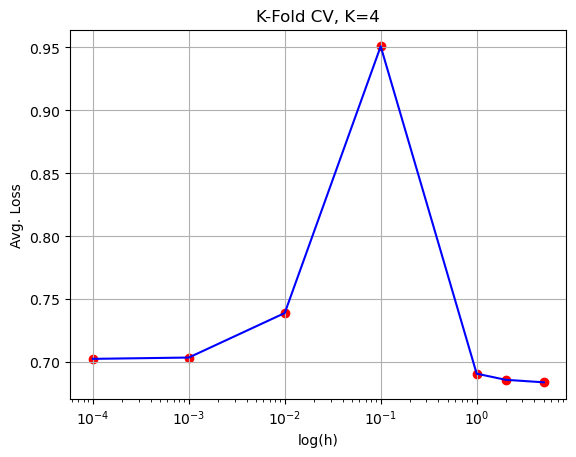

In [269]:
h_opt = cross_validate_h(X_tensor, games, hs=[.0001,.001,.01, .1, 1, 2, 5],
                         lbda=.0001, lr=0.01, epochs=250, k_folds=4, show_progress=True)

In [270]:
print(h_opt)

5


In [271]:
theta_opt = optimize_theta(X_tensor, games, h=h_opt, lbda = .001, lr=.01, epochs=500)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.6931472420692444
Epoch 50, Loss: 0.6833617091178894
Epoch 100, Loss: 0.6830295920372009
Epoch 150, Loss: 0.6829619407653809
Epoch 200, Loss: 0.6829394102096558
Epoch 250, Loss: 0.6829299926757812
Epoch 300, Loss: 0.6829254627227783
Epoch 350, Loss: 0.6829229593276978
Epoch 400, Loss: 0.6829215884208679
Epoch 450, Loss: 0.6829204559326172


### Training Accuracy

In [272]:
get_accuracy(torch.zeros(X_tensor.shape[0]), theta_opt, games, X_tensor, X_tensor, h=h_opt)

tensor(0.5543)

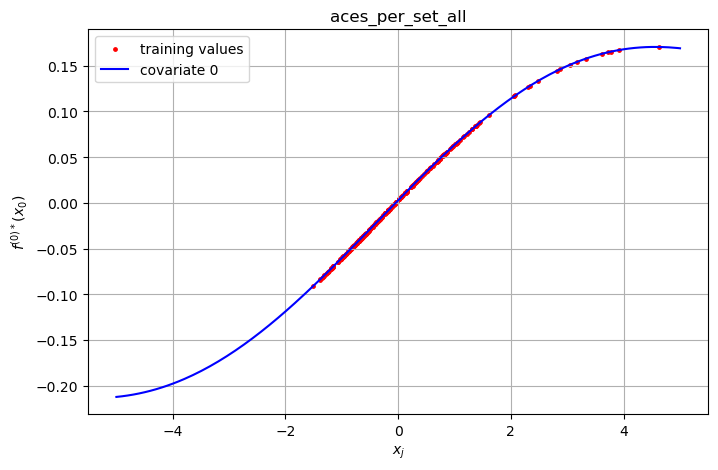

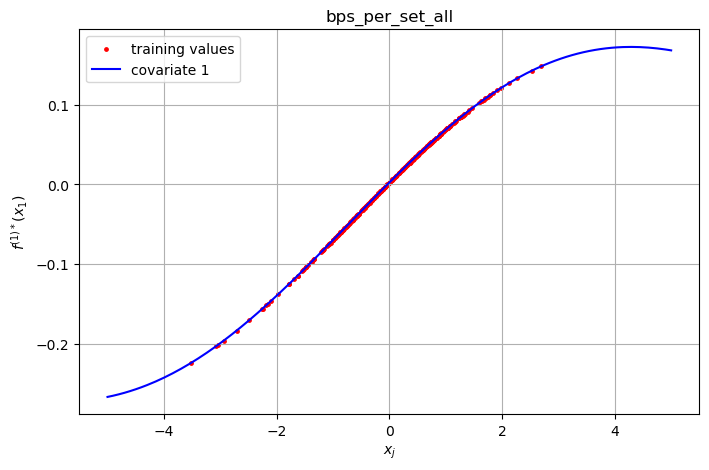

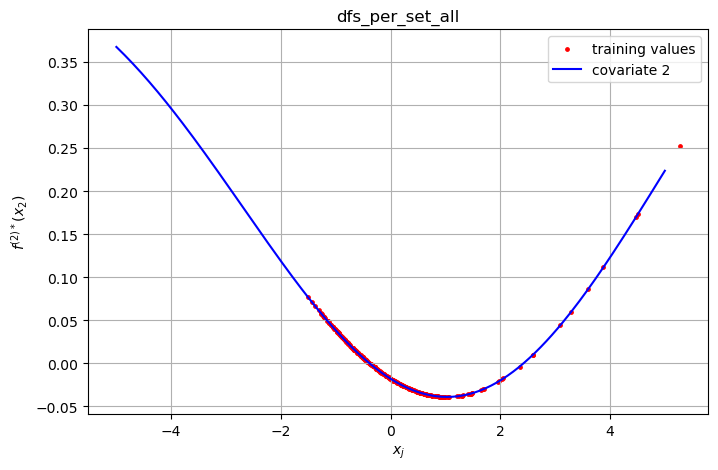

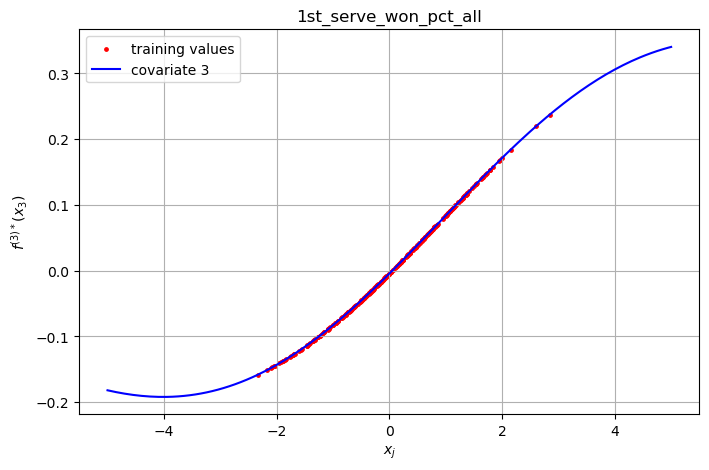

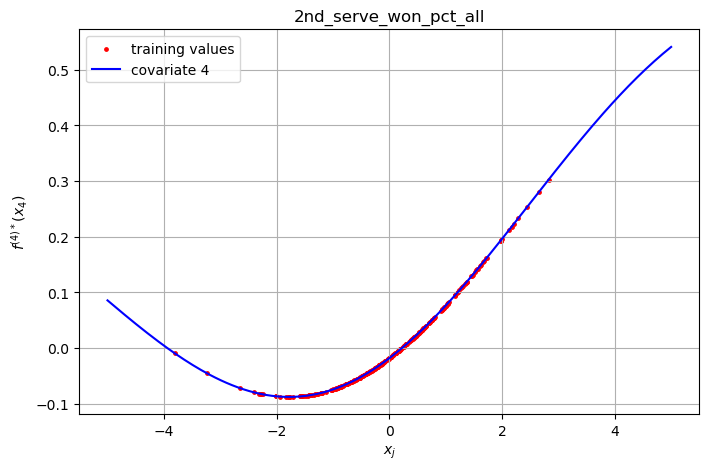

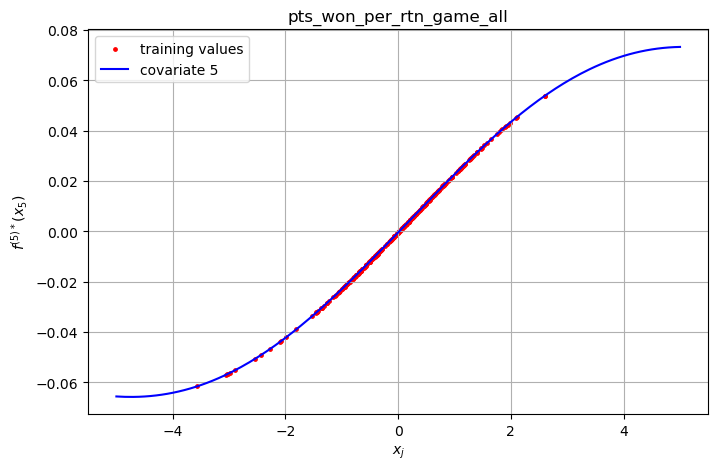

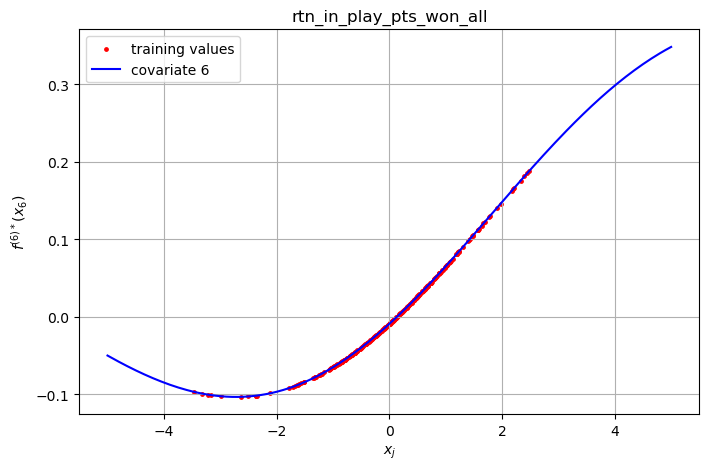

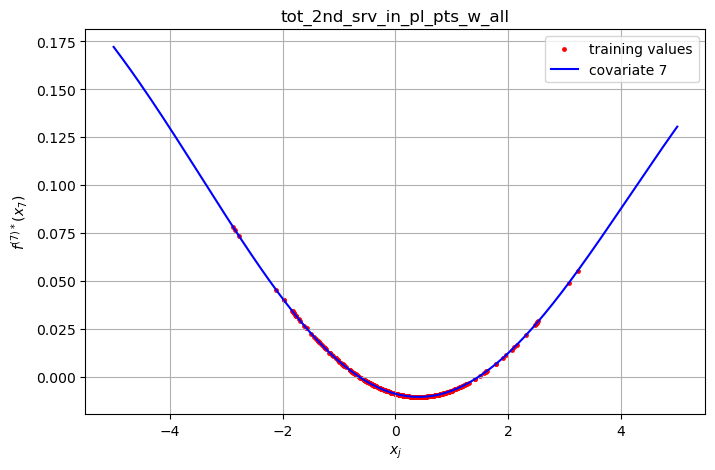

In [273]:
for J in range(8):
    plot_GAM(J, torch.linspace(-5, 5, 200), X_tensor, theta_opt, h=h_opt)

In [168]:
predictions = predict_new_matches(torch.zeros(X_tensor.shape[0]), theta_opt, games, X_tensor, X_tensor, h=h_opt)
print('max probability: {}'.format(predictions.max()))
print('min probability: {}'.format(predictions.min()))
print('average probability: {}'.format(predictions.mean()))

max probability: 0.704128623008728
min probability: 0.2851472496986389
average probability: 0.5093249678611755


# Testing on New Data:

Will compare to random selection

In [274]:
# pulling testing data

covariates_2022 = pull_data(CoI, ['2022'])['2022'][1]
atp_2023 = pd.read_csv('ATP_matches/atp_matches_2023.csv')
atp_2023['player1'] = atp_2023.loc[:,'winner_name']
atp_2023['player2'] = atp_2023.loc[:,'loser_name']
atp_2023['result'] = 1
atp_2023 = atp_2023[['result', 'player1', 'player2', 'score']]

games_2023, X_2022 = filter_and_replace_with_indices(atp_2023, covariates_2022)
games_2023 = games_2023.iloc[:,:-1]

for column in X_2022.columns:
    if X_2022[column].dtype not in ['int64', 'float64']:
        X_2022[column] =X_2022[column].str.rstrip('%').astype(float)
        
X_2022 = apply_transform(X_2022, transform)

X_2022 = torch.Tensor(X_2022.values)
games_2023 = torch.Tensor(games_2023.values)

C:\Users\jonat\AppData\Local\Temp\ipykernel_23908\1576468488.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2022[column] =X_2022[column].str.rstrip('%').astype(float)
C:\Users\jonat\AppData\Local\Temp\ipykernel_23908\1614222624.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df.loc[:,col] - mean)/std


In [275]:
alpha_0 = torch.zeros(X_2022.shape[0])
theta_0 = torch.zeros(X_tensor.shape[1], X_tensor.shape[0])
X_0 = torch.zeros_like(X_2022)

In [276]:
print('testing loss of GAM: {}'.format(get_testing_loss(alpha_0, theta_opt, games_2023, X_tensor, X_2022, h=h_opt)))
print('testing accuracy of GAM: {}'.format(get_accuracy(alpha_0, theta_opt, games_2023, X_tensor, X_2022, h=h_opt)))

testing loss of GAM: 0.6665093898773193
testing accuracy of GAM: 0.619006872177124


In [277]:
print('testing loss of coinflip: {}'.format(get_testing_loss(alpha_0, theta_0, games_2023, X_tensor, X_2022, h=h_opt)))

testing loss of coinflip: 0.6931473016738892
